In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools # for CIPS
import time

import torch
from torch.utils.data import DataLoader
from utils import move_to, load_model, torch_load_cpu, get_inner_model  # Import the load_model function from utils
from problems.MCLP.problem_MCLP import MCLP  # Make sure to import from the correct module

from IPython.display import display, HTML

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Helper functions and Generate different distributions

In [2]:
# generate m random demand points
def generate_random_demand_points(m, x_range=(0, 1), y_range=(0, 1)):
    """
    Generate demand points using uniform distribution in a given range.
    
    :param m: Number of demand points
    :param x_range: Range for x-coordinate
    :param y_range: Range for y-coordinate
    :return: Array of generated demand points
    """
    x_coords = np.random.uniform(x_range[0], x_range[1], m)
    y_coords = np.random.uniform(y_range[0], y_range[1], m)
    return np.vstack((x_coords, y_coords)).T


# Generate random demand points using normal (Gaussian) distribution
def generate_random_demand_points_normal(m, x_mean=0.5, y_mean=0.5, x_std=0.2, y_std=0.2):
    """
    Generate demand points using Normal distribution, points are concentrated around the mean.
    
    :param m: Number of demand points
    :param x_mean: Mean value for x-coordinate
    :param y_mean: Mean value for y-coordinate
    :param x_std: Standard deviation for x-coordinate
    :param y_std: Standard deviation for y-coordinate
    :return: Array of generated demand points
    """
    x_coords = np.random.normal(x_mean, x_std, m)
    y_coords = np.random.normal(y_mean, y_std, m)
    # Make sure the points within the [0, 1] 
    x_coords = np.clip(x_coords, 0, 1)
    y_coords = np.clip(y_coords, 0, 1)
    return np.vstack((x_coords, y_coords)).T


# Generate random demand points using bimodal (two peaks) distribution
def generate_random_demand_points_bimodal(m, center1=(0.3, 0.3), center2=(0.7, 0.7), std=0.1):
    """
    Generate demand points using a bimodal distribution (two centers).
    
    :param m: Number of demand points
    :param center1: Coordinates of the first center
    :param center2: Coordinates of the second center
    :param std: Standard deviation for both centers
    :return: Array of generated demand points
    """
    m1 = m // 2  # Half points around the first center
    m2 = m - m1  # Remaining points around the second center
    # Generate points around the first center
    x_coords1 = np.random.normal(center1[0], std, m1)
    y_coords1 = np.random.normal(center1[1], std, m1)
    # Generate points around the second center
    x_coords2 = np.random.normal(center2[0], std, m2)
    y_coords2 = np.random.normal(center2[1], std, m2)
    
    x_coords = np.concatenate((x_coords1, x_coords2))
    y_coords = np.concatenate((y_coords1, y_coords2))
    
    # Ensure the points stay within the [0, 1] range
    x_coords = np.clip(x_coords, 0, 1)
    y_coords = np.clip(y_coords, 0, 1)
    return np.vstack((x_coords, y_coords)).T

def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")

    return total_demand_covered

def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

### GBH method to generate inital CLS

In [3]:
# Round demand points to the nearest grid points
def round_to_grid(demand_points, grid_size):
    """
    Round demand points to the nearest grid center instead of the grid intersection points.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param grid_size: Size of the grid (e.g., sqrt(2) * coverage_radius or user-defined)
    :return: Array of rounded grid points centered in each grid cell
    """
    # Shift the points by half a grid size before rounding to move them to grid centers
    return np.round((demand_points + grid_size / 2) / grid_size) * grid_size - grid_size / 2

# Expand grid points by shifting them in four directions
def expand_grid_points(grid_points, radius, shift_ratio=0.5):
    """
    Expand the grid points by shifting them in four directions: up-left, up-right, down-left, down-right.
    
    :param grid_points: Array of grid point coordinates (x, y)
    :param radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius (default is 1/2)
    :return: Array of expanded candidate points, including the original grid points and the shifted ones
    """
    expanded_points = []
    shifts = [(shift_ratio * radius, shift_ratio * radius), 
              (-shift_ratio * radius, shift_ratio * radius), 
              (shift_ratio * radius, -shift_ratio * radius), 
              (-shift_ratio * radius, -shift_ratio * radius)]
    
    for point in grid_points:
        expanded_points.append(point)  # Add the original grid point
        for shift in shifts:
            expanded_points.append(point + np.array(shift))  # Add the shifted point (original point + shift)
    
    return np.array(expanded_points)


# Generate Candidate Location Set (CLS) using GBH algorithm
def generate_cls(demand_points, coverage_radius, shift_ratio=0.5, grid_size=None):
    """
    Generate the Candidate Location Set (CLS) using the GBH algorithm.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius
    :return: Array of candidate points (CLS)
    """
    
    if grid_size is None:
        grid_size = np.sqrt(2) * coverage_radius  # Default value
        
    rounded_points = round_to_grid(demand_points, grid_size)
    expanded_candidates = expand_grid_points(rounded_points, coverage_radius, shift_ratio)
    
    return expanded_candidates

### Filtering the generated CLS

In [75]:
# Function to calculate covered demand points for a given candidate
def calculate_covered(demand_points, candidate, radius):
    """
    Calculate which demand points are covered by the given candidate point.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate: Candidate point coordinates (x, y)
    :param radius: Coverage radius
    :return: Array of covered demand points
    """
    distances = np.linalg.norm(demand_points - candidate, axis=1)
    return demand_points[distances <= radius]


# Function to filter candidate points that do not cover any demand points or are out of bounds
def filter_candidate_points(demand_points, candidate_points, coverage_radius, bounds=(0, 1)):
    """
    Filter out candidate points that do not cover any demand points or are out of bounds.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param bounds: A tuple representing the (min, max) bounds for both x and y coordinates
    :return: Filtered array of candidate points that cover at least one demand point and are within bounds
    """
    filtered_candidates = []
    
    min_bound, max_bound = bounds  # Unpack bounds
    
    for candidate in candidate_points:
        # Check if the candidate is within the specified bounds
        if np.all(candidate >= min_bound) and np.all(candidate <= max_bound):
            covered_points = calculate_covered(demand_points, candidate, coverage_radius)
            if len(covered_points) > 0:  # Keep candidates that cover at least one demand point
                filtered_candidates.append(candidate)
    
    return np.array(filtered_candidates)

# Function to calculate discounted coverage for each candidate
def calculate_discounted_coverage(demand_points, candidate_points, coverage_radius):
    """
    Calculate the discounted coverage for each candidate, where the contribution of a demand point is shared among 
    all candidates that cover it.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :return: List of tuples (candidate, discounted_coverage)
    """
    # Step 1: Initialize dictionaries to store the coverage of each demand point
    demand_coverage_count = {tuple(dp): 0 for dp in demand_points}  # Tracks how many candidates cover each demand point
    candidate_coverage = {tuple(cp): 0 for cp in candidate_points}  # Tracks the discounted coverage of each candidate
    
    # Step 2: Calculate how many candidates cover each demand point
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            demand_coverage_count[tuple(dp)] += 1  # Increment the count for each demand point
    
    # Step 3: Calculate the discounted coverage for each candidate
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            # Discount the coverage contribution by the number of candidates covering this demand point
            candidate_coverage[tuple(candidate)] += 1 / demand_coverage_count[tuple(dp)]
    
    # Step 4: Convert the dictionary to a list of tuples for sorting
    return [(candidate, candidate_coverage[tuple(candidate)]) for candidate in candidate_points]

# Function to remove the least effective candidate points based on discounted coverage
def remove_least_effective_candidates_with_discount(demand_points, candidate_points, coverage_radius, final_count):
    """
    Remove candidate points that have the least effective discounted coverage until only final_count candidates remain.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param final_count: The number of final candidate points to retain
    :return: Array of remaining candidate points after removing the least effective ones
    """
    # Step 1: Calculate the discounted coverage for each candidate
    candidate_discounted_coverage = calculate_discounted_coverage(demand_points, candidate_points, coverage_radius)
    
    # Step 2: Sort candidates by their discounted coverage in ascending order
    candidate_discounted_coverage.sort(key=lambda x: x[1])  # Sort by discounted coverage (ascending)
    
    # Step 3: Keep the top candidates with the highest discounted coverage, discard the rest
    # Keep only the top 'final_count' candidates
    remaining_candidates = [item[0] for item in candidate_discounted_coverage[-final_count:]]  
    
    return np.array(remaining_candidates)


# Function to calculate discounted coverage with demand values for each candidate
def calculate_discounted_coverage_with_demand(demand_points, demand_vals, candidate_points, coverage_radius):
    """
    Calculate the discounted coverage for each candidate, considering the demand value of each demand point, where the 
    contribution of a demand point is shared among all candidates that cover it.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param demand_vals: Array of demand values corresponding to demand points
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :return: List of tuples (candidate, discounted_coverage)
    """
    # Step 1: Initialize dictionaries to store the coverage of each demand point
    demand_coverage_count = {tuple(dp): 0 for dp in demand_points}  # Tracks how many candidates cover each demand point
    candidate_coverage = {tuple(cp): 0 for cp in candidate_points}  # Tracks the discounted coverage of each candidate
    
    # Step 2: Calculate how many candidates cover each demand point
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            demand_coverage_count[tuple(dp)] += 1  # Increment the count for each demand point
    
    # Step 3: Calculate the discounted coverage for each candidate considering demand values
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            dp_index = np.where(np.all(demand_points == dp, axis=1))[0][0]  # Get the index of the demand point
            demand_value = demand_vals[dp_index]  # Get the demand value for this demand point
            # Discount the coverage contribution by the number of candidates covering this demand point, weighted by demand value
            candidate_coverage[tuple(candidate)] += demand_value / demand_coverage_count[tuple(dp)]
    
    # Step 4: Convert the dictionary to a list of tuples for sorting
    return [(candidate, candidate_coverage[tuple(candidate)]) for candidate in candidate_points]

# Function to remove the least effective candidate points based on discounted coverage with demand values
def remove_least_effective_candidates_with_discount_and_demand(demand_points, demand_vals, candidate_points, coverage_radius, final_count):
    """
    Remove candidate points that have the least effective discounted coverage (considering demand values) until only 
    final_count candidates remain.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param demand_vals: Array of demand values corresponding to demand points
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param final_count: The number of final candidate points to retain
    :return: Array of remaining candidate points after removing the least effective ones
    """
    # Step 1: Calculate the discounted coverage for each candidate, considering demand values
    candidate_discounted_coverage = calculate_discounted_coverage_with_demand(demand_points, demand_vals, candidate_points, coverage_radius)
    
    # Step 2: Sort candidates by their discounted coverage in ascending order
    candidate_discounted_coverage.sort(key=lambda x: x[1])  # Sort by discounted coverage (ascending)
    
    # Step 3: Keep the top candidates with the highest discounted coverage, discard the rest
    remaining_candidates = [item[0] for item in candidate_discounted_coverage[-final_count:]]  
    
    return np.array(remaining_candidates)


### Plot the points and CLS

In [187]:
# Plot the demand points and candidate points (CLS)
def plot_points(demand_points, candidate_points):
    """
    Plot the demand points and candidate points (CLS).
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c='blue', label='Demand Points', s=10)
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points and Candidate Points (CLS)')
    plt.show()
     
    
def plot_points_with_grid(demand_points, candidate_points, grid_size):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Plot demand points as blue dots
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c='blue', label='Demand Points', s=20, alpha=0.7)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()

    
def plot_points_demands_with_grid(demand_points, demand_vals, candidate_points, grid_size):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    

def plot_points_only(demand_points, demand_vals):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()

    
    
def plot_points_vals_with_grid(demand_points, demand_vals, candidate_points, grid_size):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    
    
def plot_points_vals_cov_with_grid(demand_points, demand_vals, candidate_points, grid_size, selected_idxes, radius):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')
    
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    
    
def plot_points_vals_cov_with_all_grid(demand_points, demand_vals, candidate_points, cls, grid_size, selected_idxes, radius):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(cls[:, 0], cls[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')
    
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()

### Data Initialization

Total candidate points: 1500
Unique candidate points: 265
Total candidate points after filtering: 245
Final CLS Remaining: 80


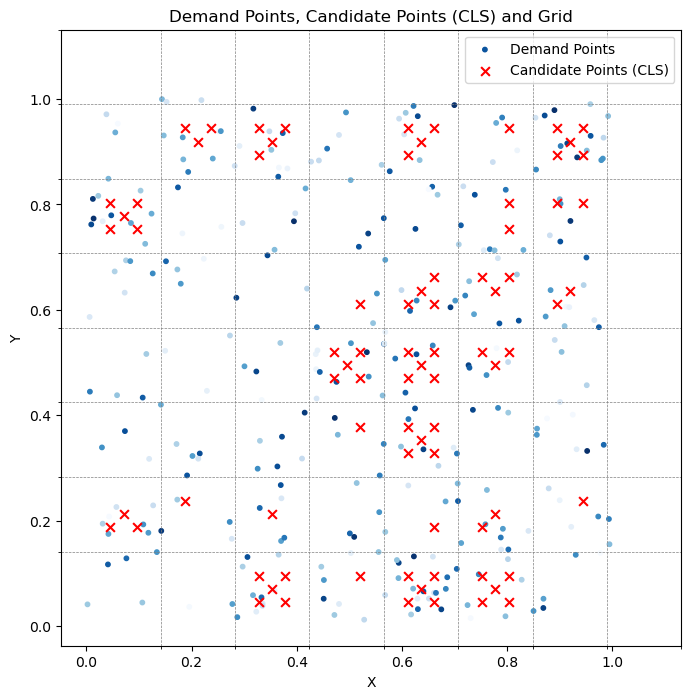

In [76]:
# data
m = 300   # number of demand points
n = 80  # Number of points to finally retain
r = 0.1  # number of demand points
p = 20
np.random.seed(1234)

demand_pts = generate_random_demand_points(m)  # Generating Uniform distribution demand points in the [0,1] range
demand_vals = np.random.uniform(1, 10, (m, 1))

## GBH ####################################################################
shift_ratio = 0.25 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * r

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_pts, r, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_pts, unique_candidate_points, r, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage

#cls = remove_least_effective_candidates_with_discount(demand_pts, filtered_candidate_points, r, n)
cls = remove_least_effective_candidates_with_discount_and_demand(demand_pts, demand_vals, filtered_candidate_points, r, n)

# Print the result
print(f"Final CLS Remaining: {len(cls)}")

# Plot the final result


plot_points_vals_with_grid(demand_pts, demand_vals, cls, grid_size)

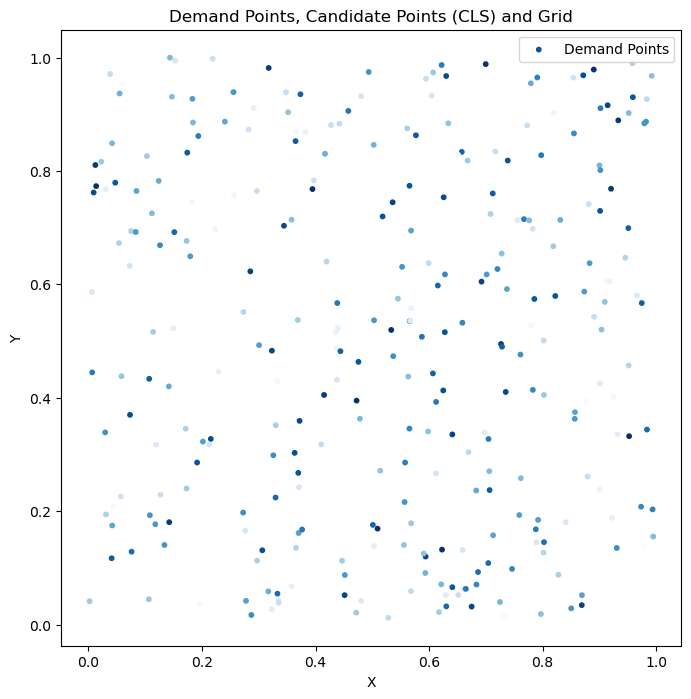

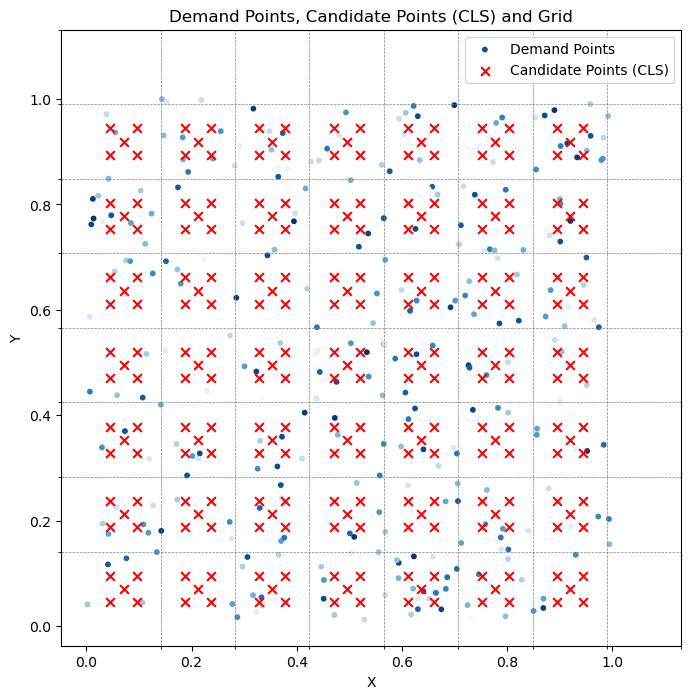

In [24]:
plot_points_only(demand_pts, demand_vals)

plot_points_demands_with_grid(demand_pts, demand_vals, filtered_candidate_points, grid_size)

### GBH Greedy

In [190]:
len(filtered_candidate_points)

245

The running time of DRL is: 0.025200366973876953
Number of covered demand points: 221
[1224.76604207]


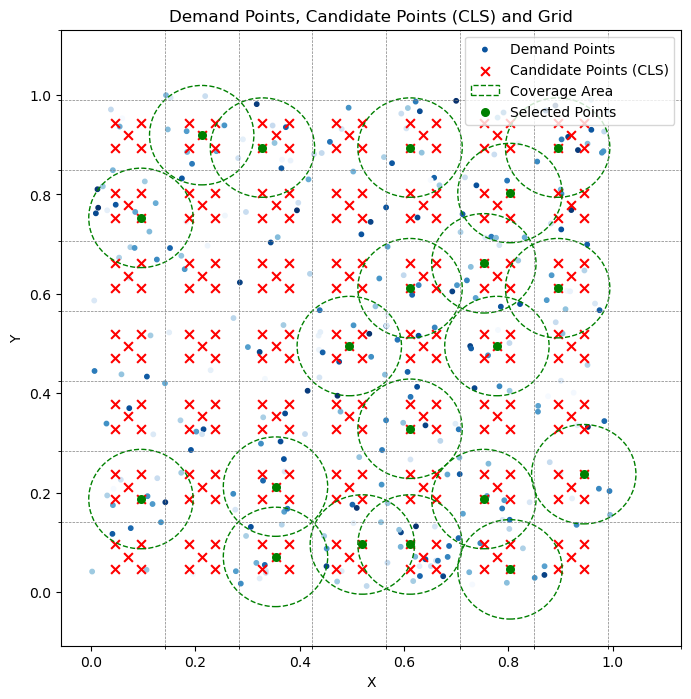

In [188]:
def calculate_covered(demand_points, candidate, radius):
    """
    Calculate which demand points are covered by the given candidate point.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate: Candidate point coordinates (x, y)
    :param radius: Coverage radius
    :return: Array of covered demand points
    """
    distances = np.linalg.norm(demand_points - candidate, axis=1)
    return demand_points[distances <= radius]

def greedy_select_facilities(demand_points, candidate_points, coverage_radius, p):
    """
    Select p facilities that maximize coverage of demand points.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param p: Number of facilities to select
    :return: Indices of the selected facilities
    """
    selected_facilities = []
    remaining_demand_points = demand_points.copy()

    for _ in range(p):
        best_candidate = None
        max_covered = -1
        best_index = -1
        
        # Iterate over all candidate points to find the one that covers the most demand points
        for i, candidate in enumerate(candidate_points):
            covered_points = calculate_covered(remaining_demand_points, candidate, coverage_radius)
            if len(covered_points) > max_covered:
                max_covered = len(covered_points)
                best_candidate = candidate
                best_index = i

        # Add the best candidate to the selected facilities
        selected_facilities.append(best_index)
        
        # Remove the covered demand points from the remaining ones
        remaining_demand_points = np.array([pt for pt in remaining_demand_points 
                                            if np.linalg.norm(pt - best_candidate) > coverage_radius])
        
        # Stop if there are no more demand points to cover
        if len(remaining_demand_points) == 0:
            break

    return selected_facilities

start = time.time()
greedy_selected_indices = greedy_select_facilities(demand_pts, cls, r, p)
end = time.time() - start
print(f"The running time of DRL is: {end}")

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, greedy_selected_indices)
print(obj_val)

plot_points_vals_cov_with_all_grid(demand_pts, demand_vals, cls, filtered_candidate_points, \
                                   grid_size, greedy_selected_indices, r)

The running time of DRL is: 0.023875713348388672
Number of covered demand points: 221
[1224.76604207]


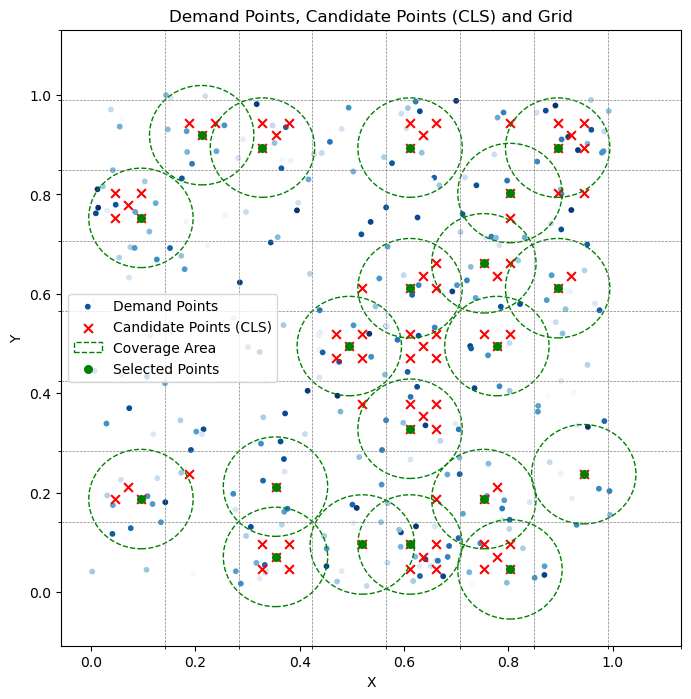

In [183]:
start = time.time()
greedy_selected_indices = greedy_select_facilities(demand_pts, cls, r, p)
end = time.time() - start
print(f"The running time of DRL is: {end}")

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, greedy_selected_indices)
print(obj_val)

plot_points_vals_cov_with_grid(demand_pts, demand_vals, cls, grid_size, greedy_selected_indices, r)

### DeepGridMCLP

In [77]:
n_users = m
n_facilities = n
p = p
r = r

dataset = MCLP.make_dataset(None, n_users, n_facilities, 1, 0, p, r, None)
dataset.data[0]['users'] = torch.FloatTensor(demand_pts)
dataset.data[0]['demand'] = torch.FloatTensor(demand_vals)
dataset.data[0]['facilities'] = torch.FloatTensor(cls)


dataloader = DataLoader(dataset, batch_size=1)

# get the first batch
batch = next(iter(dataloader))
batch = move_to(batch, device)

model_path = '../outputs/MCLP/300_80_20_20241008T161209_0.1/epoch-299.pt'  # Adjust this path to your saved model\n",
model, opts = load_model(model_path)  # load_model returns the model and options used during training\n",

  [*] Loading model from ../outputs/MCLP/300_80_20_20241008T161209_0.1/epoch-299.pt


In [181]:
start = time.time()
results = []

num_sample = 1
opts['eval_batch_size'] = 1
opts['max_calc_batch_size'] = 1280000

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("sampling")
opts['decode_strategy'] = 'sampling'
width = 1280 if opts['decode_strategy'] == 'sampling' else 0

with torch.no_grad():
    if opts['decode_strategy'] in ('sampling', 'greedy'):
        if opts['decode_strategy'] == 'greedy':
            assert width == 0, "Do not set width when using greedy"
            assert opts["eval_batch_size"] <= opts["max_calc_batch_size"], \
                "eval_batch_size should be smaller than calc batch size"
            batch_rep = 1
            iter_rep = 1
        elif width * opts["eval_batch_size"] > opts["max_calc_batch_size"]:
            assert opts["eval_batch_size"] == 1
            assert width % opts["max_calc_batch_size"] == 0
            batch_rep = opts["max_calc_batch_size"]
            iter_rep = width // opts["max_calc_batch_size"]
        else:
            batch_rep = width
            iter_rep = 1
        assert batch_rep > 0
        
        # 模型采样
        sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
        batch_size = len(costs)
        ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)

        if sequences is None:
            sequences = [None] * batch_size
            costs = [math.inf] * batch_size
        else:
            sequences, costs = get_best(
                sequences.cpu().numpy(), costs.cpu().numpy(),
                ids.cpu().numpy() if ids is not None else None,
                batch_size
            )
        duration = time.time() - start
        for seq, cost in zip(sequences, costs):
            seq = seq.tolist()
            results.append((cost, seq, duration))
            
# output
costs, tours, durations = zip(*results)
print(f"The objective is: {-costs[0]}")
print(tours[0])
end = time.time() - start
print(f"The running time of DRL is: {end}")

The objective is: 1227.021484375
[5, 57, 34, 58, 30, 13, 42, 35, 33, 16, 37, 67, 15, 24, 41, 56, 8, 76, 14, 78]
The running time of DRL is: 0.06696367263793945


Number of covered demand points: 219
[1249.17339948]


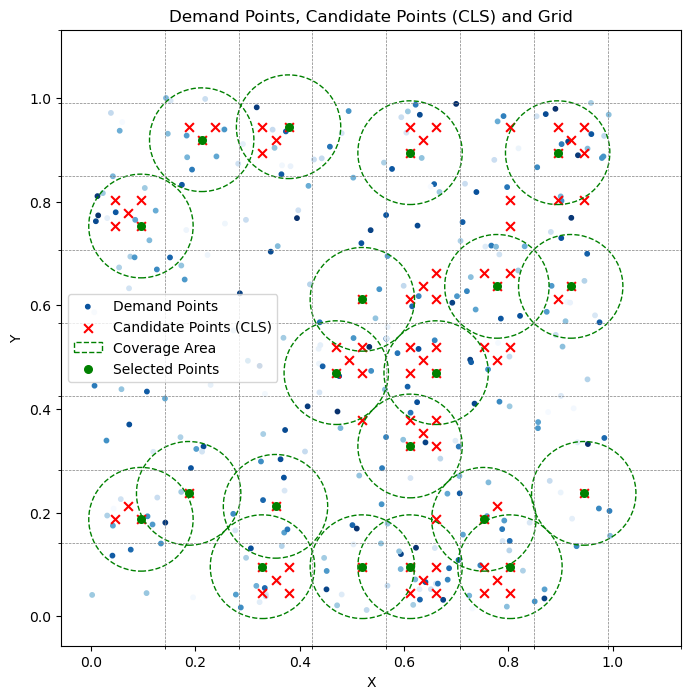

In [140]:
obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, tours[0])
print(obj_val)

plot_points_vals_cov_with_grid(demand_pts, demand_vals, cls, grid_size, tours[0], r)